# [Project 5: Camera Calibration and Fundamental Matrix Estimation with RANSAC]

## Brief
- Due: November 22, 2021 11:59 pm
- Hand-in: through Gradescope
- Required files:
    - \<your_gt_username\>.zip
    - \<your_gt_username\>.pdf
    
All projects in this course will be done with these jupyter notebooks. These are convenient ways for you to easily interact with your code. A notebook contains many blocks of code, each of which can be run independently.

There are multiple ways that you can run a cell:

1. Run the current cell, and stay in the current cell 
    - ctrl+enter on Windows and 
    - Linux cmd+enter on MacOS
2. Run the current cell, move to the next cell:
    - shift+enter
    - Click the "Run" button in the toolbar

### Description
In this project, we are going to deal with camera and scene geometry. Specifically, we will estimate the
camera projection matrix, which maps 3D world coordinates to image coordinates, as well as the fundamental matrix, which relates points in one scene to epipolar lines in another. The camera projection matrix and fundamental matrix can each be estimated using point correspondences. To estimate the projection matrix (camera calibration), the input is corresponding 3D and 2D points. To estimate the fundamental matrix the input is corresponding 2D points across two images. You will start by estimating the projection matrix and the fundamental matrix for a scene with ground-truth correspondences. 

The next part of the project involves estimating the fundamental matrix using RANSAC (already implemented by the TAs) and comparing the results of fundamental matrix estimation with and without RANSAC. The final portion of the project involves using the concepts you have learned to perform visual odometry and answer the corresponding reflection questions in the report.

### Extra Credits

- **Section 4 (TODO 7) of this project (Visualization of Fundamental Matrix & Comparison between RANSAC and non RANSAC) is optional(Extra Credit) for undergraduate students (4476), but required for graduate students (6476)**
- **gtSAM (TODO 10): BONUS For Grad Students ONLY. Undergrads can attempt this part but won't receive any extra credit for it.** 

### Parts of the project:

There are 6 parts to this project with 5 of them requiring you to write codes. For the third part, the codes have already been given to you and will be used later in part 4. 

1. Camera Projection Matrix  
    - `calculate_projection_matrix` (TODO 1)
    - `projection` (TODO 2)
    - `calculate_camera_center` (TODO 3)
2. Fundamental Matrix Estimation
    - `normalize_points` (TODO 4)
    - `unnormalize_F` (TODO 5)
    - `estimate_fundamental_matrix` (TODO 6)
3. Fundamental Matrix with RANSAC
4. Visualization of Fundamental Matrix & Comparison of the results from (2) and (3)
    - `compute_fundamental_matrix_ransac` (TODO 7)
5. Using F-Matrix Estimation w/ RANSAC for Visual Odometry
    - `get_visual_odometry` (TODO 8)
    - `compute_absolute_poses` (TODO 9)
6. gtSAM:
    - `compute_gtSAM` [TODO 10]

### Important Note:
You will only be working in the following file:

1. `student_code.py`

## Setup

In [3]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import (
    verify,
    evaluate_points,
    visualize_points,
    visualize_points_image,
    plot3dview,
    load_image,
    draw_epipolar_lines,
    get_matches,
    show_correspondence2
)

## Part 1: Camera Projection Matrix

The goal is to compute the projection matrix that goes from world 3D coordinates to 2D image coordinates.
Recall that using homogeneous coordinates the equation for moving from 3D world to 2D camera coordinates is:

\begin{equation}
\left(\begin{array}{l}
u \\
v \\
1
\end{array}\right) \cong\left(\begin{array}{c}
u * s \\
v * s \\
s
\end{array}\right)=\left(\begin{array}{llll}
m_{11} & m_{12} & m_{13} & m_{14} \\
m_{21} & m_{22} & m_{23} & m_{24} \\
m_{31} & m_{32} & m_{33} & m_{34}
\end{array}\right)\left(\begin{array}{l}
X \\
Y \\
Z \\
1
\end{array}\right)
\end{equation}

Here, $X, Y, Z$ are the world 3D coordinates and $u, v$ are the 2D image coordinates. To compute the projection matrix, we can rewrite the same equations as:

\begin{align}
\begin{gathered}
u=\frac{m_{11} X+m_{12} Y+m_{13} Z+m_{14}}{m_{31} X+m_{32} Y+m_{33} Z+m_{34}} \\
\rightarrow\left(m_{31} X+m_{32} Y+m_{33} Z+m_{34}\right) u=m_{11} X+m_{12} Y+m_{13} Z+m_{14} \\
\rightarrow 0=m_{11} X+m_{12} Y+m_{13} Z+m_{14}-m_{31} u X-m_{32} u Y-m_{33} u Z-m_{34} u \\
\rightarrow=\frac{m_{21} X+m_{22} Y+m_{23} Z+m_{24}}{m_{31} X+m_{32} Y+m_{33} Z+m_{34}} \\
\rightarrow\left(m_{31} X+m_{32} Y+m_{33} Z+m_{34}\right) v=m_{21} X+m_{22} Y+m_{23} Z+m_{24} \\
\rightarrow 0=m_{21} X+m_{22} Y+m_{23} Z+m_{24}-m_{31} v X-m_{32} v Y-m_{33} v Z-m_{34} v
\end{gathered}
\end{align}

We can thus set up a linear regression to find the elements of the matrix M. However, the matrix M is only defined up to a scale. Therefore, these equations have many different possible solutions (in particular M = all zeros is a solution, which is not very helpful in our context). We can solve this by fixing a scale and then doing the regression. One common way is to use the singular value decomposition to directly solve the constrained optimization problem:

\begin{equation}
\begin{array}{ll}
\arg \min _{x} & \|A x\| \\
\text { s.t. } & \|x\|=1
\end{array}
\end{equation}

The above equation can be solved using singular value decomposition. The solution to the above equation involves computing the SVD of A and then considering the last row of the $V$ matrix as the elements of the projection matrix (after reshaping). For those, who are interested in understanding the derivation for this logic, have a look at [Tom´aˇs Svoboda](http://cmp.felk.cvut.cz/cmp/courses/XE33PVR/WS20072008/Lectures/Supporting/constrained_lsq.pdf) lecture on "Least–squares Solution of Homogeneous Equations". For the coding part, you will find the `np.linalg.svd` function particularly useful. 

### Calculate the camera center using M found from the previous step

Once you have an accurate projection matrix $M$, it is possible to tease it apart into the more familiar and more useful matrix $K$ of intrinsic parameters and matrix $[R \mid T]$ of extrinsic parameters. For this project, we will only ask you to estimate one particular extrinsic parameter: the camera center in world coordinates. Let us define $M$ as being composed of a $3 \times 3$ matrix, $Q$, and a 4th column, $m_{4}:$

$$
M=\left[\begin{array}{l}
Q & m_{4}
\end{array}\right]
$$
Now, the center of the camera $C$ could be found by:
$$
C=-Q^{-1} m_{4}
$$

We've also provided a visualization that will show the estimated $3 \mathrm{D}$ location of the camera with respect to the normalized $3 \mathrm{D}$ point coordinates.

### Calculating the projection matrix given corresponding 2D & 3D points

**TASK 1 : Complete TODOS 1,2,3**

First, you will need to implement the least-squares regression to solve for M given the corresponding normalized points. The starter code will load 20 corresponding normalized 2D and 3D points. You have to
write the code to set up the linear system of equations, solve for the unknown entries of M, and reshape it
into the estimated projection matrix. You are required to code up `calculate_projection_matrix`, `calculate_camera_center`, and `projection` functions in `student_code.py` respectively. The details for these functions are given below:

- `projection()`: Projects homogeneous world coordinates $[X, Y, Z, 1]$ to non-homogeneous image coordinates $(u, v)$. Given projection matrix $M$, the equations that accomplish this are given above.
- `calculate_projection_matrix()`: Solves for the camera projection matrix using a system of equations set up from corresponding $2 \mathrm{D}$ and $3 \mathrm{D}$ points.
- `calculate_camera_center()`: Computes the camera center location in world coordinates.

In [47]:
# Load the data
img_path = '../data/CCB_GaTech/pic_a.jpg'
points_2d = np.loadtxt('../data/CCB_GaTech/pts2d-norm-pic_a.txt')
points_3d = np.loadtxt('../data/CCB_GaTech/pts3d-norm.txt')

# (Optional) Uncomment these four lines once you have your code working with the easier, normalized points above.
# img_path = '../data/CCB_GaTech/pic_a.jpg'
# points_2d = np.loadtxt('../data/CCB_GaTech/pts2d-pic_b.txt')
# points_3d = np.loadtxt('../data/CCB_GaTech/pts3d.txt')

In [48]:
from proj5_code.student_code import calculate_projection_matrix, calculate_camera_center

from proj5_unit_tests.test_part1 import (
    test_projection,
    test_calculate_projection_matrix,
    test_calculate_camera_center)

To validate that you’ve found a reasonable projection matrix, we’ve provided evaluation code which computes the total "residual" between the projected 2D location of each 3D point and the actual location of that point in the 2D image. The residual is just the distance (square root of the sum of squared differences in $u$ and $v$). This should be very small.

In [49]:
print('projection():', verify(test_projection))

projection(): "Correct"


The projection matrix is
 [[ 0.45827553 -0.29474238 -0.01395749  0.00402579]
 [-0.05085589 -0.0545847  -0.5410599  -0.05237592]
 [ 0.10900958  0.1783455  -0.04426782  0.5968205 ]]
The total residual is 0.002227


<IPython.core.display.Javascript object>


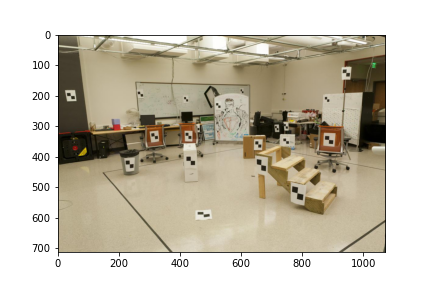

<IPython.core.display.Javascript object>


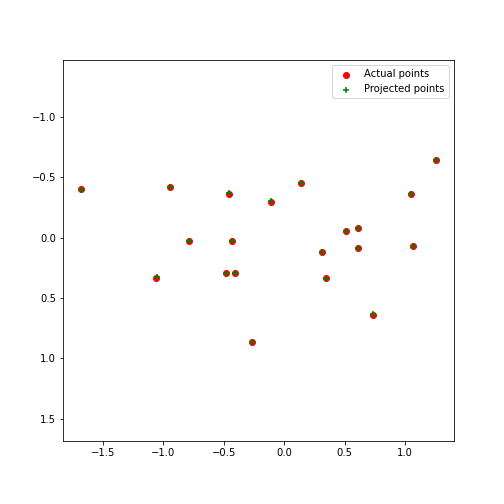

In [50]:
M = calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', M)

[projected_2d_pts, residual] = evaluate_points(M, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
plt.figure(); plt.imshow(load_image(img_path))
visualize_points(points_2d, projected_2d_pts)

In [52]:
print('calculate_projection_matrix():', verify(test_calculate_projection_matrix))

calculate_projection_matrix(): "Correct"


The estimated location of the camera is <-1.5127, -2.3517, 0.2826>


<IPython.core.display.Javascript object>


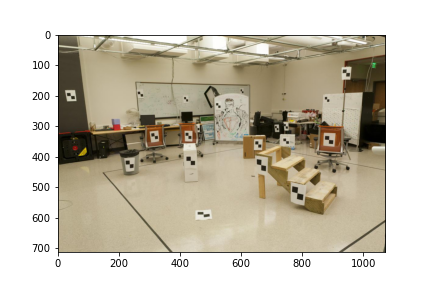

<IPython.core.display.Javascript object>


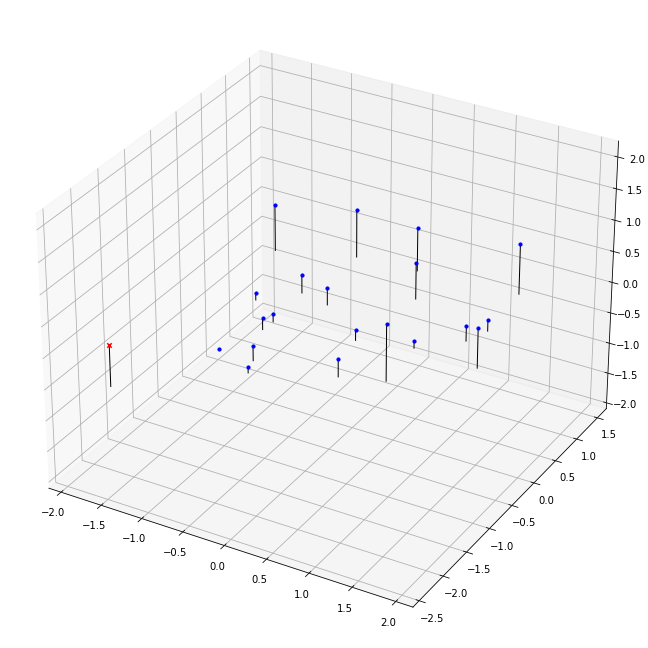

In [53]:
center = calculate_camera_center(M);
print('The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>'.format(*center))
plt.figure(); plt.imshow(load_image(img_path))
ax = plot3dview(points_3d, center)

In [55]:
print('test_calculate_camera_center():', verify(test_calculate_camera_center))

test_calculate_camera_center(): "Correct"


### Reflection Questions
1. Is it possible to decompose the projection matrix $P$ into the corresponding components $K$, and $R$?

## Camera Calibration for Argoverse image data

Argoverse dataset is developed by Argo AI, in collaboration with faculty and students from Carnegie Mellon University and Georgia Institute of Technology. It is inspired by the [KITTI dataset](http://www.cvlibs.net/datasets/kitti/) and is a publicly available dataset for research into self-driving vehicle perception. The dataset contains high-quality curated data and detailed maps to improve 3D tracking and motion forecasting models. For more details on the Argoverse dataset, please look at this [link](https://www.argoverse.org/index.html). 

Using the codes that were implemented previously, we will estimate the position of a camera mounted on an autonomous vehicle in the Argoverse dataset. We'll use images from the "ring front center" camera, which faces the forward direction of the vehicle. The 3D and 2D point correspondences are given below. Two sample scenes have been provided below.

<img src="https://www.argoverse.org/assets/images/reference_images/O2V4_vehicle_annotation.jpg" alt="Drawing" style="width: 400px;"/>

In [56]:
# Argoverse Scene 2
#img_path = '../data/argoverse_log_d60558d2_pair2/pic2.jpg'
#points_2d = np.loadtxt('../data/argoverse_log_d60558d2_pair2/points_2d.txt')
#points_3d = np.loadtxt('../data/argoverse_log_d60558d2_pair2/points_3d.txt')


# Argoverse Scene 3
img_path = '../data/argoverse_log_d60558d2_pair3/pic3.jpg'
points_2d = np.loadtxt('../data/argoverse_log_d60558d2_pair3/points_2d.txt')
points_3d = np.loadtxt('../data/argoverse_log_d60558d2_pair3/points_3d.txt')

The projection matrix is
 [[-3.2103518e-01  4.7891057e-01  4.6795709e-03  5.3224760e-01]
 [-2.0147242e-01  1.6693916e-03  4.7723192e-01 -3.4048060e-01]
 [-3.4047643e-04  4.2718607e-06  3.9787269e-06  5.6367030e-04]]
The total residual is 0.000043


<IPython.core.display.Javascript object>


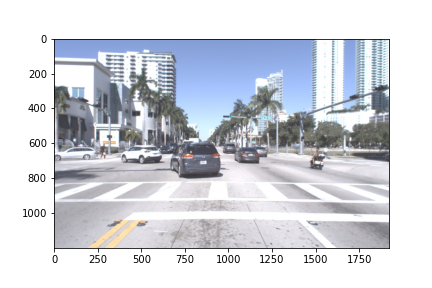

<IPython.core.display.Javascript object>


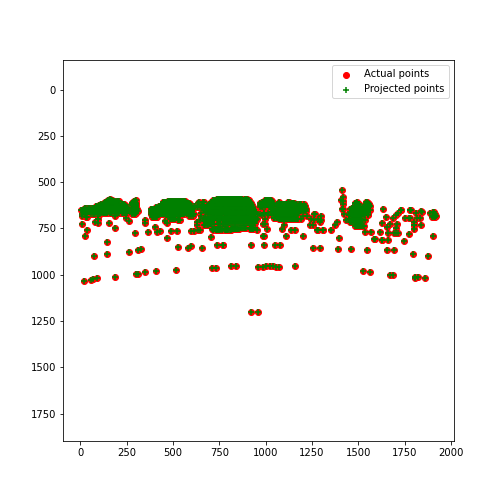

In [57]:
M = calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', M)

[projected_2d_pts, residual] = evaluate_points(M, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
plt.figure(); plt.imshow(load_image(img_path))
visualize_points(points_2d, projected_2d_pts)

For these 2d-3d pairs, the "world" frame is defined as the "ego-vehicle" frame, where the origin is at the center of the back axle of the vehicle.

Thus, if your camera center estimate is correct, it should tell you how far to move forward (+x) and how far to move left (+y) and move up (+z) to reach the camera's position.


The "egovehicle" coordinate system and "camera" coordinate system:
<img width="300"  src="https://user-images.githubusercontent.com/16724970/108759169-034e6180-751a-11eb-8a06-fbe344f1ee68.png">
<img width="300" src="https://user-images.githubusercontent.com/16724970/108759182-06495200-751a-11eb-8162-8b17f9cdee4b.png">

The estimated location of the camera is <1.6721, -0.0044, 1.4194>


<IPython.core.display.Javascript object>


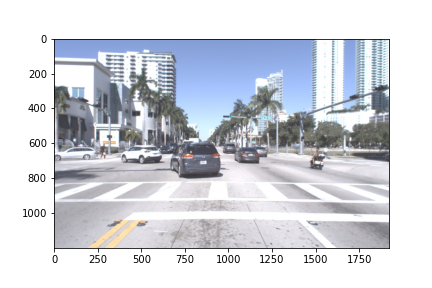

<IPython.core.display.Javascript object>


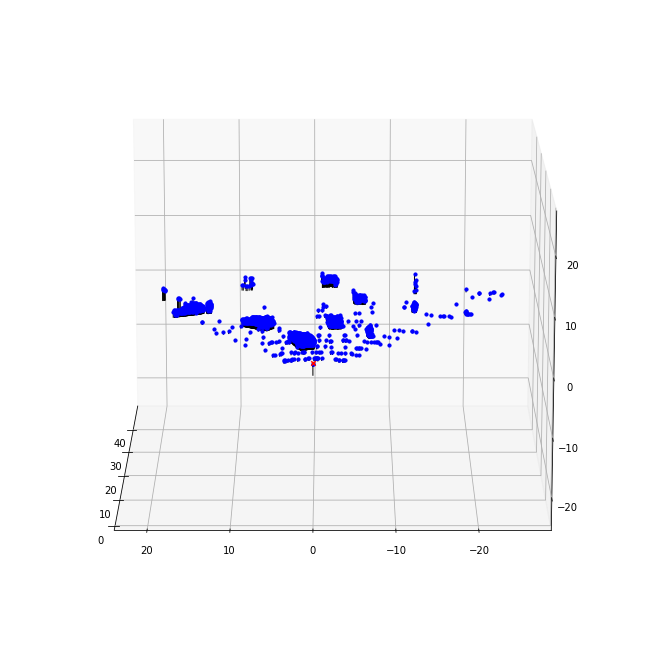

In [58]:
center = calculate_camera_center(M);
print('The estimated location of the camera is <{:.4f}, {:.4f}, {:.4f}>'.format(*center))
plt.figure(); plt.imshow(load_image(img_path))
ax = plot3dview(points_3d, center)
ax.view_init(elev=15, azim=180)

## Part 2: Fundamental Matrix Estimation
We'll now solve for the Fundamental Matrix by implementing [Hartley's 8-Point algorithm](https://www.cse.unr.edu/~bebis/CS485/Handouts/hartley.pdf).

In this part of the project, we will estimate the mapping of points in one image to lines in another by
means of the fundamental matrix. This will require you to use similar methods to those in part 1. We will
make use of the corresponding point locations listed in pts2d-pic_a.txt and pts2d-pic_b.txt. Recall that
the definition of the fundamental matrix is

\begin{equation}
\left(\begin{array}{lll}
u^{\prime} & v^{\prime} & 1
\end{array}\right)\left(\begin{array}{lll}
f_{11} & f_{12} & f_{13} \\
f_{21} & f_{22} & f_{23} \\
f_{31} & f_{32} & f_{33}
\end{array}\right)\left(\begin{array}{l}
u \\
v \\
1
\end{array}\right)=0
\end{equation}

for a point $(u; v; 1)$ in image A, and a point $(u'; v'; 1)$ in image B.  Note: the fundamental matrix is sometimes defined as the transpose of the above matrix with the left and right image points swapped. Both are valid fundamental matrices, but the visualization functions in the starter code assume you use the above form. The above equation can also be written as:

\begin{equation}
\left(f_{11} u u^{\prime}+f_{12} v u^{\prime}+f_{13} u^{\prime}+f_{21} u v^{\prime}+f_{22} v v^{\prime}+f_{23} v^{\prime}+f_{31} u+f_{32} v+f_{33}\right)=0
\end{equation}

Given corresponding points, you get one equation per point pair. With 8 or more points you can solve this (why 8?). Similar to part 1, there’s an issue here where the matrix is only defined up to scale and the degenerate zero solution solves these equations. So you need to solve using the same method you used in part 1 of first fixing the scale and then solving the regression.

### Important Note 1 (Rank 2 Matrix)
The least-squares estimate of $F$ is full rank; however, a proper fundamental matrix is a rank $2.$ As such we must reduce its rank. To do this, we can decompose $F$ using singular value decomposition into the matrices $U \Sigma V^{\prime}=F$. We can then construct a rank 2 matrix by setting the smallest singular value in $\Sigma$ to zero thus generating $\Sigma_{2}$. The fundamental matrix is then easily calculated as $F=U \Sigma_{2} V^{\prime}$. You can check your fundamental matrix estimation by plotting the epipolar lines using the plotting function provided in the starter code. A simple pseudo-code for making $F$ a rank 2 matrix is given below:

\begin{equation}
\begin{gathered}
{[u, d, v^{\prime}]=\operatorname{svd}(F)} \\
\text { new_d }=\operatorname{diag}([d(1,1), d(2,2), 0]) \\
F=u * \text { new_d } * v^{\prime}
\end{gathered}
\end{equation}

### Important Note 2 (Coordinate normalization)
Your estimate of the fundamental matrix can be improved by normalizing the coordinates before computing the fundamental matrix. It is suggested for this project you perform the normalization through linear transformations as described below to make the mean of the points zero and the average magnitude 1.0.

\begin{equation}
\left(\begin{array}{l}
u^{\prime} \\
v^{\prime} \\
1
\end{array}\right)=\left(\begin{array}{ccc}
s_{u} & 0 & 0 \\
0 & s_{v} & 0 \\
0 & 0 & 1
\end{array}\right)\left(\begin{array}{ccc}
1 & 0 & -c_{u} \\
0 & 1 & -c_{v} \\
0 & 0 & 1
\end{array}\right)\left(\begin{array}{l}
u \\
v \\
1
\end{array}\right)
\end{equation}

The transform matrix $T$ is the product of the scale and offset matrices. $c_{u}$ and $c_{v}$ are the mean coordinates. To compute scale $s$ you could estimate the standard deviation of the coordinates. Then the scale factor $s$ would be the reciprocal of whatever estimate of the scale you are using. You could use one scale matrix based on the statistics of the coordinates from both images or you could do it per image. A step-by-step approach for computing the normalized points is given below:

1. Compute the mean of all points. Call this $m u=[m u(1) ; m u(2)]$.
2. Compute the scaling factor. It is the reciprocal of the standard deviation of the points. Call this `scale`. 
3. Construct a homogeneous transform matrix $T$ that will be applied to each point. In pseudo code notation, $$T=\left[\right. scale, 0, -scale { }^{\star} mu(1); 0, scale, -scale \left.{ }^{*} \mathrm{mu}(2) ; 0,0,1\right]$$
4. (Pre-)Multiply each image feature (in homogeneous coordinates) by $T$ to obtain the transformed image coordinates.


Finally, in `student_code.py` you will need to use the scaling matrices to adjust your fundamental matrix so that it can operate on the original pixel coordinates. This is performed as follows:

$$
F_{o r i g}=T_{b}^{T} * F_{n o r m} * T_{a}
$$

Thus, implement the following functions in `student_code.py`:
- `normalize_points()`: Normalizes the $2 \mathrm{D}$ coordinates.
- `unnormalize_F()`: Adjusts the fundamental matrix to account for the normalized coordinates. See Appendix B.
- `estimate_fundamental_matrix()`: Calculates the fundamental matrix.

**TASK 2: Complete TODOs 4,5,6**

In [60]:
from proj5_code.student_code import estimate_fundamental_matrix

In [61]:
# Load the data
points_2d_pic_a = np.loadtxt('../data/CCB_GaTech/pts2d-pic_a.txt')
points_2d_pic_b = np.loadtxt('../data/CCB_GaTech/pts2d-pic_b.txt')
img_a = load_image('../data/CCB_GaTech/pic_a.jpg')
img_b = load_image('../data/CCB_GaTech/pic_b.jpg')

### Estimate fundamental matrix

In [62]:
from proj5_unit_tests.test_part2 import test_estimate_fundamental_matrix, test_normalize_points, test_unnormalize_F

print('test_estimate_fundamental_matrix():', verify(test_estimate_fundamental_matrix))
print('test_normalize_points():', verify(test_normalize_points))
print('test_unnormalize_F():', verify(test_unnormalize_F))

test_estimate_fundamental_matrix(): "Correct"
test_normalize_points(): "Correct"
test_unnormalize_F(): "Correct"


<IPython.core.display.Javascript object>


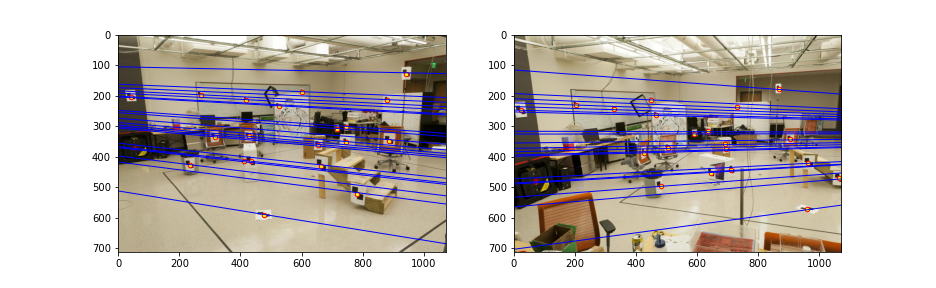

In [63]:
F = estimate_fundamental_matrix(points_2d_pic_a, points_2d_pic_b)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_a, img_b, points_2d_pic_a, points_2d_pic_b, figsize=(13,4))

### Reflection questions
1. Why do we need 8 points instead of 9 for computing the fundamental matrix?

## Part 3: Fundamental Matrix with RANSAC (Szeliski 6.1.4)

For two photographs of a scene, it’s unlikely that you’d have perfect point correspondence with which to do the regression for the fundamental matrix. So, next, you are going to compute the fundamental matrix with point correspondences computed using SIFT. As discussed in class, least squares regression alone is not appropriate in this scenario due to the presence of multiple outliers. To estimate the fundamental matrix from this noisy data you’ll need to use RANSAC in conjunction with your fundamental matrix estimation.

In this project, the RANSAC code has already been **implemented** for you. However, for completeness's sake, you can read more about RANSAC [here](https://dellaert.github.io/21F-x476/Slides/S13-Alignment.pdf). Try understanding how the RANSAC code works by looking at the functions `calculate_num_ransac_iterations` and `ransac_fundamental_matrix` respectively.

## Part 4a: Visualization of Fundamental Matrix
### Compulsory for graduates students (6476), extra credit for UG (4476)

In this part, you will first code up a function `compute_fundamental_matrix_ransac` in `student_code.py` file to estimate the fundamental matrix using the RANSAC method provided by us. This function will take as input two image paths, the corresponding image scales, and the number of detection features we need to compute the initial set of matches. Then do the following:
- Load and resize the corresponding images
- Compute the matches using the `get_matches` function implemented in utils.py file
- Use `ransac_fundamental_matrix` function to remove the outlier matches. 
- Compute the correspondences across the image pairs using `show_correspondence2` function.
- Return the correspondences in both cases both, before and after applying RANSAC.

After writing this function, answer the below-given reflection questions by plotting the results provided by `compute_fundamental_matrix_ransac` function.

**TASK 3: Complete TODO 7**

### Reflection questions
1. For all these four examples describe how the initial matches look. Visualize the epipolar lines for the image pairs that can be found in the `data` folder. The parameters that you need to pass to the `compute_fundamental_matrix_ransac` function for these four pairs of images are given below. **[Answer in Report]**

| Image Pair     | Num Features | Img 1 Path                                         | Image 2 Path                                       | Image 1 Scale | Image 2 Scale |
|----------------|--------------|----------------------------------------------------|----------------------------------------------------|---------------|---------------|
| Mount Rushmore | 5e4          | ../data/Mount_Rushmore/9193029855_2c85a50e91_o.jpg  | ../data/Mount_Rushmore/7433804322_06c5620f13_o.jpg  | 0.25          | 0.37          |
| Notre Dame     | 4e3          | ../data/Notre_Dame/921919841_a30df938f2_o.jpg       | ../data/Notre_Dame/4191453057_c86028ce1f_o.jpg      | 0.5           | 0.5           |
| Gaudi          | 2e4          | ../data/Episcopal_Gaudi/3743214471_1b5bbfda98_o.jpg | ../data/Episcopal_Gaudi/4386465943_8cf9776378_o.jpg | 0.8           | 1.0           |
| Woodruff       | 5e4          | ../data/Woodruff_Dorm/wood1.jpg                     | ../data/Woodruff_Dorm/wood2.jpg                     | 0.65          | 0.65          |

In [ ]:
from proj5_code.student_code import calculate_num_ransac_iterations, ransac_fundamental_matrix, compute_fundamental_matrix_ransac

### Compute matches and Fundamental Matrix for Each Pair

You need to use the `compute_fundamental_matrix_ransac` function you will write in this part to generate the visualizations for all the pairs of images described above. We have already described a sample function call for one of the pairs of images. Modify the parameters appropriately to get the results for other pairs of images.

In [ ]:
match_image, match_image_ransac, _, _, matched_points_ransac_a, matched_points_ransac_b, pic_a, pic_b, F_wo_ransac, F_ransac = compute_fundamental_matrix_ransac(
    img1_path='../data/Notre_Dame/921919841_a30df938f2_o.jpg', 
    img2_path='../data/Notre_Dame/4191453057_c86028ce1f_o.jpg', 
    img1_scale=0.5, 
    img2_scale=0.5, 
    num_features=4e3
)

Now that you have matched points with and without RANSAC, plot both of them below and answer the reflection questions in the report.

In [ ]:
plt.figure()
plt.title("Correspondences Without RANSAC")
plt.imshow(match_image)
plt.tight_layout()

In [ ]:
plt.figure()
plt.title("Correspondences With RANSAC")
plt.imshow(match_image_ransac)
plt.tight_layout()

Now, we can visualize the epipolar lines for our estimated fundamental matrix using the helper function `draw_epipolar_lines`.

In [ ]:
draw_epipolar_lines(F_ransac, pic_a, pic_b, matched_points_ransac_a, matched_points_ransac_b, figsize=(12,8))

## Part 4b Comparison of the results from Parts (2) and (3)
### Compulsory for graduate students (6476), extra credit for UG (4476)

#### Performance Comparison on Argoverse

We'll now test the quality of Fundamental matrices we can compute with and without RANSAC on an image pair from the [Argoverse](https://www.argoverse.org/) autonomous driving dataset. In this part, you will compare the performance of using the direct least squares method against RANSAC. You need to call the `compute_fundamental_matrix_ransac` function with appropriate arguments and can use the code in the notebook for visualization of the fundamental matrix estimation. Based on your output visualizations, answer the questions provided in the report.

#### Reflection Questions
- Does RANSAC improve the results?
- Which one (with or without RANSAC) would be more robust for real-world applications.

In [ ]:
argo_match_image, argo_match_image_ransac, argo_matched_points_wo_ransac_a, argo_matched_points_wo_ransac_b, argo_matched_points_a, argo_matched_points_b, argo_a, argo_b, argo_F_wo_ransac, argo_F_ransac = compute_fundamental_matrix_ransac(
    img1_path='../data/argoverse_log_273c1883/ring_front_center_315975640448534784.jpg', 
    img2_path='../data/argoverse_log_273c1883/ring_front_center_315975643412234000.jpg', 
    img1_scale=0.5, 
    img2_scale=0.5, 
    num_features=4e3
)

We first plot the matches that we get using our utlities function `get_matches`. 

In [ ]:
plt.figure(figsize=(14,6))
plt.imshow(argo_match_image)
plt.tight_layout()

### Without RANSAC Estimation
If we ignore RANSAC and use only our implementation from Part2, we get the following results:

In [ ]:
draw_epipolar_lines(argo_F_wo_ransac, argo_a, argo_b, argo_matched_points_wo_ransac_a, argo_matched_points_wo_ransac_b, figsize=(13,4))

### With Ransac Estimation
Now we'll use our RANSAC implementation from Part 3. The camera is mounted on an autonomous vehicle identical to the vehicle seen up ahead in the left image.

In [ ]:
plt.figure(figsize=(14,6))
plt.imshow(argo_match_image_ransac)
plt.tight_layout()

Visualizing the epipolar lines for the fundamental matrix computed using RANSAC. 

In [ ]:
draw_epipolar_lines(argo_F_ransac, argo_a, argo_b, argo_matched_points_a, argo_matched_points_b, figsize=(13,4))

## Part 5: Visual Odometry

Visual odometry (VO) is an important part of the simultaneous localization and mapping (SLAM) problem.
In this part, you will write code to implement VO on a real-world example from Argoverse. VO will
allow us to recreate most of the ego-motion of a camera mounted on a robot - the relative translation (but
only up to an unknown scale), and the relative rotation. See this [tutorial](https://ieeexplore.ieee.org/document/6096039) for a more detailed understanding. 

You will be required to code two functions (TODOs) in this part of the assignment: `get_visual_odometry` and `compute_absolute_poses`. 

The `get_visual_odometry` takes as input a directory path that contains all the images for which we want to compute the VO. You are required to read all image paths in this folder, sort them (WHY??) and then pass them to the code provided later in the function. 

The `get_visual_odometry` returns the relative poses between the different frames of the scene. In several applications, the absolute poses are very important and thus need to be computed using the relative poses. Given an initial pose (identity pose), and the relative poses, we can compute the absolute poses by composing the transformation matrices. In `compute_absolute_poses`, you will take the relative poses as input and you will output the absolute poses.

**TASK 4: Complete TODOs 8,9**

### Reflection questions
- Would you trust such a VO system running on an autonomous vehicle? What are some issues that such a system can face?
- What happens if the vehicle makes a turn and there are no good correspondences between a pair of sequential images?

In [ ]:
from proj5_code.student_code import get_visual_odometry, plot_poses, compute_absolute_poses

For the following gif, we try to obtain the visual odometry of a camera mounted on a robot from the individual image frames.

![VO](https://user-images.githubusercontent.com/16724970/100487935-34fd8b00-30d9-11eb-9941-7735fcae445c.gif "VO")

In [ ]:
# This may take a few minutes to run across 20 image frames from the Argoverse dataset
image_frames_path = os.path.join("..", "data", "vo_seq_argoverse_273c1883", "ring_front_center")
poses_relative = get_visual_odometry(image_frames_path)

In [ ]:
poses_absolute = compute_absolute_poses(poses_relative)

In [ ]:
from proj5_unit_tests.test_part4 import test_compute_absolute_poses

print("test_compute_absolute_poses(): ", verify(test_compute_absolute_poses))

In [ ]:
plot_poses(poses_absolute)

## Part 6: Estimating absolute poses using gtSAM 
### Extra credit for graduate students (6476),  no credit will be provided for (UG) 4476 students

In the previous part of this project, we first computed the relative poses by estimating the fundamental matrices between two consecutive image pairs. We then used these relative poses to compute the absolute pose and plotted the same above. 

While it is possible to compute the absolute pose in this manner, this method won't work well when there is a lot of noise in the data. In such a scenario, we can use pose graph optimization to get a more accurate estimate of the absolute poses. 

In this part of the project, we have provided two Google Colab notebooks:
1. The first notebook contains a toy pose graph optimization problem that was solved using the gtSAM library. 
2. In the second notebook, you are required to use the relative poses provided by us (`IPrevTiCurr_matrices.npy` in "data" folder) to compute the ground truth odometry. Run the remaining cells of the notebook, and finally answer the questions provided in the report

Links to the colab notebooks:
- [Colab Notebook 1](https://colab.research.google.com/drive/1m81PQfA7LXyhb-Eb6UBqqZWO4mMD28iC?usp=sharing)
- [Colab Notebook 2](https://colab.research.google.com/drive/1xkr-BjJga8gMdF2JcUEk7lO_mccRO5II?usp=sharing)

**Note**: Make your own copy of the Colab notebook and edit that notebook.